<a href="https://colab.research.google.com/github/karaage0703/karaage-ai-book/blob/master/ch02/02_karaage_ai_book_image_classification_performance.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# AIモデルの性能を性能を上げる方法

## 教師データのダウンロード

ジャンケンの手の形の教師データをGitHubからダウンロード（Clone）します。

2,3行目はダウンロードしたデータから、使用するデータ以外の不要なファイルを削除しています。

In [ ]:
!git clone https://github.com/karaage0703/janken_dataset datasets
!rm -rf /content/datasets/.git
!rm /content/datasets/LICENSE

Cloning into 'datasets'...
remote: Enumerating objects: 210, done.
remote: Total 210 (delta 0), reused 0 (delta 0), pack-reused 210
Receiving objects: 100% (210/210), 4.60 MiB | 33.15 MiB/s, done.
Resolving deltas: 100% (3/3), done.


## 教師データを訓練データ（Train Data）とテストデータ（Validation Data）に分ける

教師データのディレクトリと、ターゲットとなるディレクトリ（この下に訓練データのディレクトリと検証データのディレクトリが生成される）を指定します。

In [ ]:
dataset_original_dir = 'datasets'
dataset_root_dir = 'target_datasets'

教師データを訓練データのディレクトリ(train)と検証データのディレクトリ（val）に分割するスクリプトをダウンロードします。

スクリプトのプログラムに関しては、本ノートブックの主題では無いので割愛します。興味ある方は以下のアドレスで、ソフトの中身を確認して下さい。

https://raw.githubusercontent.com/karaage0703/karaage-ai-book/master/util/split_train_val.py

In [ ]:
!wget https://raw.githubusercontent.com/karaage0703/karaage-ai-book/master/util/split_train_val.py

--2020-10-17 17:22:06--  https://raw.githubusercontent.com/karaage0703/karaage-ai-book/master/util/split_train_val.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2683 (2.6K) [text/plain]
Saving to: ‘split_train_val.py’

split_train_val.py  100%[===================>]   2.62K  --.-KB/s    in 0s      

2020-10-17 17:22:06 (54.1 MB/s) - ‘split_train_val.py’ saved [2683/2683]



In [ ]:
import split_train_val
split_train_val.image_dir_train_val_split(dataset_original_dir, dataset_root_dir, train_size=0.67)

datasets/pa copy is done
datasets/choki copy is done
datasets/gu copy is done
processing is done


In [ ]:
train_dir = 'target_datasets/train'
val_dir = 'target_datasets/val'

## ラベルファイルの作成

学習するファイルのラベルを作成します

必要なライブラリをインポートします

In [ ]:
import sys
import os
import shutil

データを保存する場所を指定します

In [ ]:
backup_dir = './model'

ラベルデータを作成します（最後に表示される class numberが画像の種類の数です）

In [ ]:
labels = [d for d in os.listdir(dataset_original_dir) \
    if os.path.isdir(os.path.join(dataset_original_dir, d))]
labels.sort()

if os.path.exists(backup_dir):
  shutil.rmtree(backup_dir)

os.makedirs(backup_dir)

with open(backup_dir + '/labels.txt','w') as f:
  for label in labels:
    f.write(label+"\n")

NUM_CLASSES = len(labels)
print("class number=" + str(NUM_CLASSES))

class number=3


ラベルを確認します。ラベル名（choki, gu, pa）が並んでいればOKです

In [ ]:
!cat ./model/labels.txt

choki
gu
pa


## 学習の事前準備

### ライブラリのインポート

必要なライブラリをインポートします

In [ ]:
%tensorflow_version 2.x
import tensorflow as tf
print(tf.__version__)

2.3.0


続いて、他に必要なライブラリをインストールします。

In [ ]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten

from tensorflow.keras.preprocessing.image import img_to_array, load_img, ImageDataGenerator
import numpy as np
import matplotlib.pyplot as plt
import time

先ほど作成したラベルファイルから、ラベル情報を読み込みます

In [ ]:
labels = []
with open(backup_dir + '/labels.txt','r') as f:
    for line in f:
        labels.append(line.rstrip())
print(labels)

NUM_CLASSES = len(labels)

['choki', 'gu', 'pa']


### 学習のハイパーパラメータの設定

学習のハイパーパラメータの設定をします

In [ ]:
# 学習率
LEARNING_RATE = 0.001
# エポック（世代数）
EPOCHS = 20
# バッチサイズ
BATCH_SIZE = 8

### データセットの前処理

データをTensorFlowで扱える形式に変換します

In [ ]:
IMAGE_SIZE = 64

train_data_gen = ImageDataGenerator(rescale=1./255)
val_data_gen = ImageDataGenerator(rescale=1./255)

train_data = train_data_gen.flow_from_directory(
    train_dir, target_size=(IMAGE_SIZE, IMAGE_SIZE),
    color_mode='rgb', batch_size=BATCH_SIZE,
    class_mode='categorical', shuffle=True)

validation_data = val_data_gen.flow_from_directory(
    val_dir, target_size=(IMAGE_SIZE, IMAGE_SIZE),
    color_mode='rgb', batch_size=BATCH_SIZE,
    class_mode='categorical', shuffle=True)

Found 111 images belonging to 3 classes.
Found 56 images belonging to 3 classes.


## モデルの変更

In [ ]:
model_2 = Sequential()

model_2.add(Conv2D(32, (3, 3), padding='same', input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3)))
model_2.add(Activation('relu'))
model_2.add(Conv2D(32, (3, 3)))
model_2.add(Activation('relu'))
model_2.add(MaxPooling2D(pool_size=(2, 2)))
model_2.add(Dropout(0.25))

model_2.add(Conv2D(64, (3, 3), padding='same'))
model_2.add(Activation('relu'))
model_2.add(Conv2D(64, (3, 3)))
model_2.add(Activation('relu'))
model_2.add(MaxPooling2D(pool_size=(3, 3)))
model_2.add(Dropout(0.25))

model_2.add(Flatten())
model_2.add(Dense(512))
model_2.add(Activation('relu'))
model_2.add(Dropout(0.5))

model_2.add(Dense(NUM_CLASSES))
model_2.add(Activation('softmax'))

opt = tf.keras.optimizers.Adam(lr=LEARNING_RATE)
model_2.compile(opt, loss='categorical_crossentropy',
    metrics=['accuracy'])

In [ ]:
model_2.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 64, 64, 32)        896       
_________________________________________________________________
activation (Activation)      (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 62, 62, 32)        9248      
_________________________________________________________________
activation_1 (Activation)    (None, 62, 62, 32)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 31, 31, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 31, 31, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 31, 31, 64)        1

In [ ]:
%%time
history = model_2.fit(train_data, epochs=EPOCHS, validation_data=validation_data, verbose=1)

Epoch 1/20
14/14 [==============================] - 1s 48ms/step - loss: 1.1487 - accuracy: 0.2883 - val_loss: 1.0974 - val_accuracy: 0.3929
Epoch 2/20
14/14 [==============================] - 0s 28ms/step - loss: 1.0928 - accuracy: 0.4054 - val_loss: 1.0784 - val_accuracy: 0.3929
Epoch 3/20
14/14 [==============================] - 0s 28ms/step - loss: 1.0529 - accuracy: 0.4324 - val_loss: 0.9714 - val_accuracy: 0.6607
Epoch 4/20
14/14 [==============================] - 0s 29ms/step - loss: 0.7950 - accuracy: 0.7027 - val_loss: 0.7038 - val_accuracy: 0.7500
Epoch 5/20
14/14 [==============================] - 0s 29ms/step - loss: 0.5224 - accuracy: 0.8108 - val_loss: 0.4968 - val_accuracy: 0.7857
Epoch 6/20
14/14 [==============================] - 0s 28ms/step - loss: 0.3238 - accuracy: 0.9009 - val_loss: 0.4780 - val_accuracy: 0.8214
Epoch 7/20
14/14 [==============================] - 0s 29ms/step - loss: 0.2985 - accuracy: 0.8739 - val_loss: 0.5520 - val_accuracy: 0.8214
Epoch 8/20
14

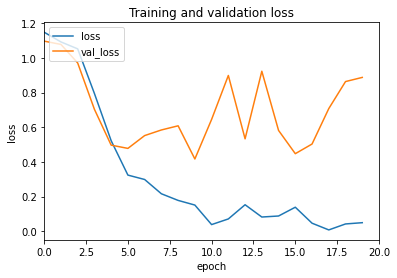

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Training and validation loss')
plt.ylabel('loss')
plt.xlim([0.0, EPOCHS])
plt.xlabel('epoch')
plt.legend(['loss', 'val_loss'], loc='upper left')
plt.show()

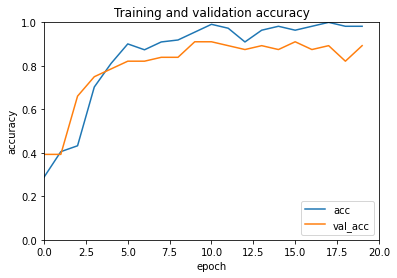

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training and validation accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.xlim([0.0, EPOCHS])
plt.ylim([0.0, 1.0])
plt.legend(['acc', 'val_acc'], loc='lower right')
plt.show()

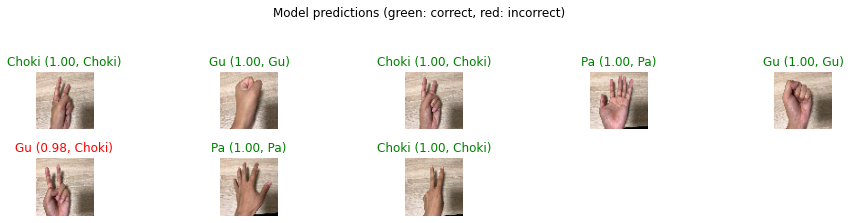

In [ ]:
# Get the ordered list of class names:
import PIL.Image as Image
class_names = validation_data.class_indices.items()
class_names = np.array([key.title() for key, value in class_names])

validation_data.reset()
validation_data.shuffle = True
validation_data.batch_size = BATCH_SIZE

# Retrieve the first batch from the validation data
for validation_image_batch, validation_label_batch in validation_data:
  break

validation_id = np.argmax(validation_label_batch, axis=-1)
validation_label = class_names[validation_id]
predicted_batch = model_2.predict(validation_image_batch)

# Returns the indices of the maximum values along a given axis
predicted_id = np.argmax(predicted_batch, axis=-1)

# Return the maximum values along a given axis
predicted_score = np.max(predicted_batch, axis=-1)

predicted_label_batch = class_names[predicted_id]

plt.figure(figsize=(16, 9))
plt.subplots_adjust(hspace=0.5)

# Display the classification results for the first 30 images
for n in range(min(validation_image_batch.shape[0], 30)):
  plt.subplot(6, 5, n + 1)

  # Convert the range from -1 to 1 to the range from 0 to 1
  plt.imshow(np.array(validation_image_batch[n]*255,np.int32))
  color = 'green' if predicted_id[n] == validation_id[n] else 'red'
  predicted_label = predicted_label_batch[n].title()
  plt.title(predicted_label + ' ({:.2f}, {})'.format(
      predicted_score[n], validation_label[n]), color=color)
  plt.axis('off')

_ = plt.suptitle('Model predictions (green: correct, red: incorrect)')

## 転移学習

### MobileNetV2

MobileNet V2を読み込みます。

In [ ]:
mobilenet_pretrained_model = tf.keras.applications.mobilenet_v2.MobileNetV2(
    input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3),
    include_top=False,
    weights= 'imagenet')

opt = tf.keras.optimizers.Adam(lr=LEARNING_RATE)

9412608/9406464 [==============================] - 0s 0us/step


In [ ]:
mobilenet_pretrained_model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 64, 64, 3)]  0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 65, 65, 3)    0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 32, 32, 32)   864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 32, 32, 32)   128         Conv1[0][0]                      
_______________________________________________________________________________

In [ ]:
(image_data, _) = train_data.next()
feature_batch = mobilenet_pretrained_model(image_data)
print(feature_batch.shape)

(8, 2, 2, 1280)


In [ ]:
mobilenet_pretrained_model.trainable = False

In [ ]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(8, 1280)


In [ ]:
prediction_layer = tf.keras.layers.Dense(NUM_CLASSES)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(8, 3)


In [ ]:
mobilenet_train_model = tf.keras.Sequential([
  mobilenet_pretrained_model,
  global_average_layer,
  prediction_layer
])

In [ ]:
mobilenet_train_model.compile(opt, loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
mobilenet_train_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Functi (None, 2, 2, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 3843      
Total params: 2,261,827
Trainable params: 3,843
Non-trainable params: 2,257,984
_________________________________________________________________


学習します。

In [ ]:
%%time
history = mobilenet_train_model.fit(train_data, epochs=EPOCHS, validation_data=validation_data, verbose=1)

Epoch 1/20
14/14 [==============================] - 1s 85ms/step - loss: 7.5501 - accuracy: 0.2162 - val_loss: 7.2923 - val_accuracy: 0.1786
Epoch 2/20
14/14 [==============================] - 0s 29ms/step - loss: 5.6127 - accuracy: 0.2162 - val_loss: 6.0379 - val_accuracy: 0.1607
Epoch 3/20
14/14 [==============================] - 0s 29ms/step - loss: 6.3579 - accuracy: 0.2432 - val_loss: 4.6132 - val_accuracy: 0.1071
Epoch 4/20
14/14 [==============================] - 0s 29ms/step - loss: 5.0497 - accuracy: 0.2162 - val_loss: 3.6335 - val_accuracy: 0.0893
Epoch 5/20
14/14 [==============================] - 0s 30ms/step - loss: 4.3003 - accuracy: 0.1622 - val_loss: 4.6038 - val_accuracy: 0.0536
Epoch 6/20
14/14 [==============================] - 0s 30ms/step - loss: 4.6584 - accuracy: 0.1351 - val_loss: 4.4938 - val_accuracy: 0.1071
Epoch 7/20
14/14 [==============================] - 0s 30ms/step - loss: 5.0285 - accuracy: 0.1351 - val_loss: 6.3600 - val_accuracy: 0.2321
Epoch 8/20
14

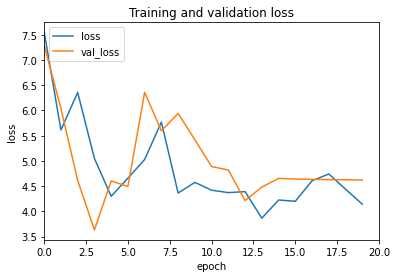

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Training and validation loss')
plt.ylabel('loss')
plt.xlim([0.0, EPOCHS])
plt.xlabel('epoch')
plt.legend(['loss', 'val_loss'], loc='upper left')
plt.show()

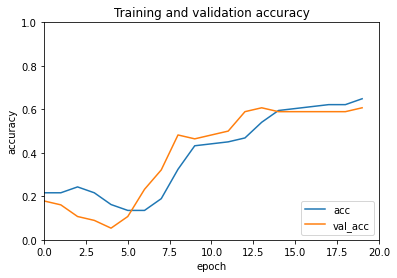

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training and validation accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.xlim([0.0, EPOCHS])
plt.ylim([0.0, 1.0])
plt.legend(['acc', 'val_acc'], loc='lower right')
plt.show()

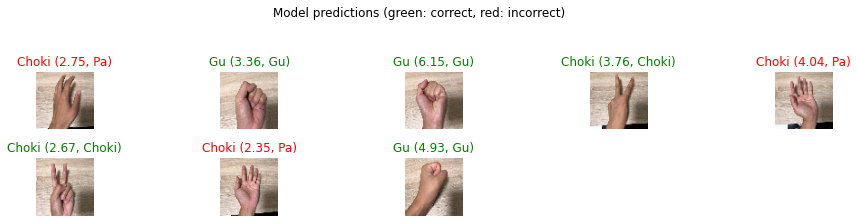

In [ ]:
# Get the ordered list of class names:
import PIL.Image as Image
class_names = validation_data.class_indices.items()
class_names = np.array([key.title() for key, value in class_names])

validation_data.reset()
validation_data.shuffle = True
validation_data.batch_size = BATCH_SIZE

# Retrieve the first batch from the validation data
for validation_image_batch, validation_label_batch in validation_data:
  break

validation_id = np.argmax(validation_label_batch, axis=-1)
validation_label = class_names[validation_id]
predicted_batch = mobilenet_train_model.predict(validation_image_batch)

# Returns the indices of the maximum values along a given axis
predicted_id = np.argmax(predicted_batch, axis=-1)

# Return the maximum values along a given axis
predicted_score = np.max(predicted_batch, axis=-1)

predicted_label_batch = class_names[predicted_id]

plt.figure(figsize=(16, 9))
plt.subplots_adjust(hspace=0.5)

# Display the classification results for the first 30 images
for n in range(min(validation_image_batch.shape[0], 30)):
  plt.subplot(6, 5, n + 1)

  # Convert the range from -1 to 1 to the range from 0 to 1
  plt.imshow(np.array(validation_image_batch[n]*255,np.int32))
  color = 'green' if predicted_id[n] == validation_id[n] else 'red'
  predicted_label = predicted_label_batch[n].title()
  plt.title(predicted_label + ' ({:.2f}, {})'.format(
      predicted_score[n], validation_label[n]), color=color)
  plt.axis('off')

_ = plt.suptitle('Model predictions (green: correct, red: incorrect)')

Instructions for updating:
Please use Model.predict, which supports generators.


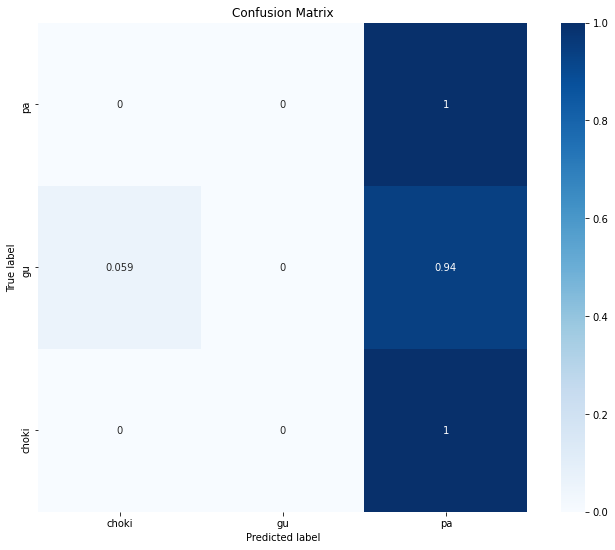

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

validation_data.reset()
validation_data.shuffle =  False
validation_data.batch_size = 1

# Retrieve the first batch from the validation data
for validation_image_batch, validation_label_batch in validation_data:
  break

predicted = mobilenet_train_model.predict_generator(validation_data, steps=validation_data.n)
predicted_classes = np.argmax(predicted, axis=-1)

# Apply normalization
# https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
cm = confusion_matrix(validation_data.classes, predicted_classes)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(12, 9))

# https://seaborn.pydata.org/generated/seaborn.heatmap.html
# https://matplotlib.org/users/colormaps.html
sns.heatmap(cm, annot=True, square=True, cmap=plt.cm.Blues,
            xticklabels=validation_data.class_indices,
            yticklabels=validation_data.class_indices)

plt.title("Confusion Matrix")
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.xlim([0.0, 3.0])
plt.ylim([0.0, 3.0])
plt.show()

### EfficientNet

In [ ]:
import tensorflow_hub as hub

In [ ]:
feature_extractor_url = "https://tfhub.dev/google/efficientnet/b0/feature-vector/1" #@param {type:"string"}

In [ ]:
feature_extractor_layer = hub.KerasLayer(feature_extractor_url,
    input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3))

In [ ]:
feature_extractor_layer.trainable = False

In [ ]:
efficientnet_model = tf.keras.Sequential([
  feature_extractor_layer,
  tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
])

In [ ]:
efficientnet_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 1280)              4049564   
_________________________________________________________________
dense_3 (Dense)              (None, 3)                 3843      
Total params: 4,053,407
Trainable params: 3,843
Non-trainable params: 4,049,564
_________________________________________________________________


In [ ]:
efficientnet_model.compile(opt, loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
%%time
history = efficientnet_model.fit(train_data, epochs=EPOCHS, validation_data=validation_data, verbose=1)

Epoch 1/20
14/14 [==============================] - 1s 82ms/step - loss: 0.8163 - accuracy: 0.6036 - val_loss: 0.4857 - val_accuracy: 0.8393
Epoch 2/20
14/14 [==============================] - 0s 31ms/step - loss: 0.1773 - accuracy: 0.9550 - val_loss: 0.1572 - val_accuracy: 0.9643
Epoch 3/20
14/14 [==============================] - 0s 30ms/step - loss: 0.0574 - accuracy: 1.0000 - val_loss: 0.1304 - val_accuracy: 0.9643
Epoch 4/20
14/14 [==============================] - 0s 31ms/step - loss: 0.0356 - accuracy: 1.0000 - val_loss: 0.1228 - val_accuracy: 0.9643
Epoch 5/20
14/14 [==============================] - 0s 32ms/step - loss: 0.0289 - accuracy: 1.0000 - val_loss: 0.1220 - val_accuracy: 0.9464
Epoch 6/20
14/14 [==============================] - 0s 31ms/step - loss: 0.0250 - accuracy: 1.0000 - val_loss: 0.1156 - val_accuracy: 0.9643
Epoch 7/20
14/14 [==============================] - 0s 33ms/step - loss: 0.0218 - accuracy: 1.0000 - val_loss: 0.1095 - val_accuracy: 0.9643
Epoch 8/20
14

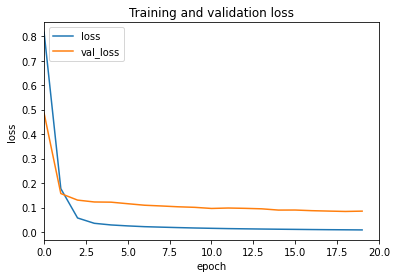

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Training and validation loss')
plt.ylabel('loss')
plt.xlim([0.0, EPOCHS])
plt.xlabel('epoch')
plt.legend(['loss', 'val_loss'], loc='upper left')
plt.show()

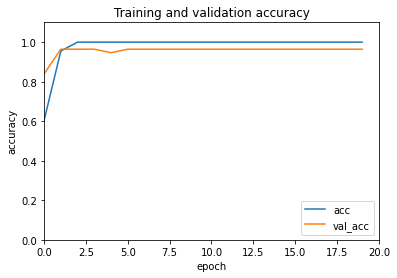

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training and validation accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.xlim([0.0, EPOCHS])
plt.ylim([0.0, 1.1])
plt.legend(['acc', 'val_acc'], loc='lower right')
plt.show()

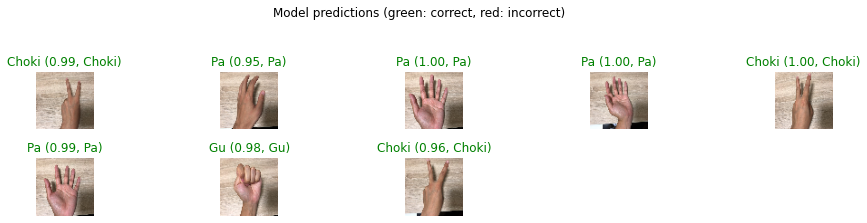

In [ ]:
# Get the ordered list of class names:
import PIL.Image as Image
class_names = validation_data.class_indices.items()
class_names = np.array([key.title() for key, value in class_names])

validation_data.reset()
validation_data.shuffle = True
validation_data.batch_size = BATCH_SIZE

# Retrieve the first batch from the validation data
for validation_image_batch, validation_label_batch in validation_data:
  break

validation_id = np.argmax(validation_label_batch, axis=-1)
validation_label = class_names[validation_id]
predicted_batch = efficientnet_model.predict(validation_image_batch)

# Returns the indices of the maximum values along a given axis
predicted_id = np.argmax(predicted_batch, axis=-1)

# Return the maximum values along a given axis
predicted_score = np.max(predicted_batch, axis=-1)

predicted_label_batch = class_names[predicted_id]

plt.figure(figsize=(16, 9))
plt.subplots_adjust(hspace=0.5)

# Display the classification results for the first 30 images
for n in range(min(validation_image_batch.shape[0], 30)):
  plt.subplot(6, 5, n + 1)

  # Convert the range from -1 to 1 to the range from 0 to 1
  plt.imshow(np.array(validation_image_batch[n]*255,np.int32))
  color = 'green' if predicted_id[n] == validation_id[n] else 'red'
  predicted_label = predicted_label_batch[n].title()
  plt.title(predicted_label + ' ({:.2f}, {})'.format(
      predicted_score[n], validation_label[n]), color=color)
  plt.axis('off')

_ = plt.suptitle('Model predictions (green: correct, red: incorrect)')

Instructions for updating:
Please use Model.predict, which supports generators.


Instructions for updating:
Please use Model.predict, which supports generators.


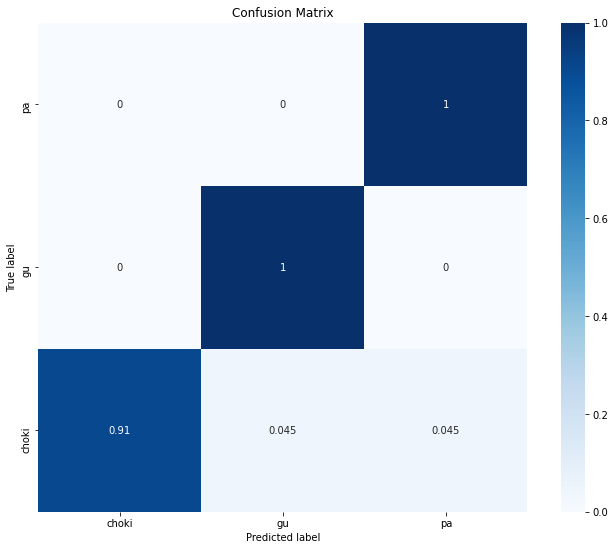

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

validation_data.reset()
validation_data.shuffle =  False
validation_data.batch_size = 1

# Retrieve the first batch from the validation data
for validation_image_batch, validation_label_batch in validation_data:
  break

predicted = efficientnet_model.predict_generator(validation_data, steps=validation_data.n)
predicted_classes = np.argmax(predicted, axis=-1)

# Apply normalization
# https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
cm = confusion_matrix(validation_data.classes, predicted_classes)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(12, 9))

# https://seaborn.pydata.org/generated/seaborn.heatmap.html
# https://matplotlib.org/users/colormaps.html
sns.heatmap(cm, annot=True, square=True, cmap=plt.cm.Blues,
            xticklabels=validation_data.class_indices,
            yticklabels=validation_data.class_indices)

plt.title("Confusion Matrix")
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.xlim([0.0, 3.0])
plt.ylim([0.0, 3.0])
plt.show()

## データ水増し

データをデータ水増し用のディレクトリにコピー

In [ ]:
!cp -r ./target_datasets/train ./target_datasets/train_aug
!cp ./datasets/choki/choki_01.jpg ./target_datasets/train_aug/choki

データ水増し用のディレクトリを定義

In [ ]:
train_aug_dir = 'target_datasets/train_aug'

必要なライブラリをインポート

In [ ]:
import cv2
import numpy as np
import sys
import os
import glob

In [ ]:
# ヒストグラム均一化
def equalizeHistRGB(src):
    RGB = cv2.split(src)
    Blue   = RGB[0]
    Green = RGB[1]
    Red    = RGB[2]
    for i in range(3):
        cv2.equalizeHist(RGB[i])

    img_hist = cv2.merge([RGB[0],RGB[1], RGB[2]])
    return img_hist

# ガウシアンノイズ
def addGaussianNoise(src):
    row,col,ch= src.shape
    mean = 0
    var = 0.1
    sigma = 15
    gauss = np.random.normal(mean,sigma,(row,col,ch))
    gauss = gauss.reshape(row,col,ch)
    noisy = src + gauss

    return noisy

# salt&pepperノイズ
def addSaltPepperNoise(src):
    row,col,ch = src.shape
    s_vs_p = 0.5
    amount = 0.004
    out = src.copy()
    # Salt mode
    num_salt = np.ceil(amount * src.size * s_vs_p)
    coords = [np.random.randint(0, i-1 , int(num_salt))
                 for i in src.shape]
    out[coords[:-1]] = (255,255,255)

    # Pepper mode
    num_pepper = np.ceil(amount* src.size * (1. - s_vs_p))
    coords = [np.random.randint(0, i-1 , int(num_pepper))
             for i in src.shape]
    out[coords[:-1]] = (0,0,0)
    return out

In [ ]:
labels = os.listdir(dataset_original_dir)

image_file_names = []

for label in labels:
  image_files = glob.glob(train_aug_dir + '/' + label +'/*')
  for image_file in image_files:
    image_file_names.append(image_file)

print(image_file_names)

['target_datasets/train_aug/pa/IMG_0856.JPG', 'target_datasets/train_aug/pa/IMG_0838.JPG', 'target_datasets/train_aug/pa/IMG_0850.JPG', 'target_datasets/train_aug/pa/IMG_0837.JPG', 'target_datasets/train_aug/pa/IMG_0866.JPG', 'target_datasets/train_aug/pa/IMG_0832.JPG', 'target_datasets/train_aug/pa/IMG_0865.JPG', 'target_datasets/train_aug/pa/IMG_0857.JPG', 'target_datasets/train_aug/pa/IMG_0821.JPG', 'target_datasets/train_aug/pa/IMG_0834.JPG', 'target_datasets/train_aug/pa/IMG_0847.JPG', 'target_datasets/train_aug/pa/IMG_0826.JPG', 'target_datasets/train_aug/pa/IMG_0841.JPG', 'target_datasets/train_aug/pa/IMG_0835.JPG', 'target_datasets/train_aug/pa/IMG_0827.JPG', 'target_datasets/train_aug/pa/IMG_0849.JPG', 'target_datasets/train_aug/pa/IMG_0824.JPG', 'target_datasets/train_aug/pa/IMG_0831.JPG', 'target_datasets/train_aug/pa/IMG_0822.JPG', 'target_datasets/train_aug/pa/IMG_0830.JPG', 'target_datasets/train_aug/pa/IMG_0851.JPG', 'target_datasets/train_aug/pa/IMG_0840.JPG', 'target_d

In [ ]:
# ルックアップテーブルの生成
min_table = 50
max_table = 205
diff_table = max_table - min_table
gamma1 = 0.75
gamma2 = 1.5

LUT_HC = np.arange(256, dtype = 'uint8' )
LUT_LC = np.arange(256, dtype = 'uint8' )
LUT_G1 = np.arange(256, dtype = 'uint8' )
LUT_G2 = np.arange(256, dtype = 'uint8' )

LUTs = []

# 平滑化用
average_square = (10,10)

# ハイコントラストLUT作成
for i in range(0, min_table):
  LUT_HC[i] = 0

for i in range(min_table, max_table):
  LUT_HC[i] = 255 * (i - min_table) / diff_table

for i in range(max_table, 255):
  LUT_HC[i] = 255

# その他LUT作成
for i in range(256):
  LUT_LC[i] = min_table + i * (diff_table) / 255
  LUT_G1[i] = 255 * pow(float(i) / 255, 1.0 / gamma1)
  LUT_G2[i] = 255 * pow(float(i) / 255, 1.0 / gamma2)

LUTs.append(LUT_HC)
LUTs.append(LUT_LC)
LUTs.append(LUT_G1)
LUTs.append(LUT_G2)


for image_file in image_file_names:
#  print(image_file)
  # 画像の読み込み
  img_src = cv2.imread(image_file, 1)
  trans_img = []
  trans_img.append(img_src)

  # LUT変換
  for i, LUT in enumerate(LUTs):
    trans_img.append(cv2.LUT(img_src, LUT))

	# 平滑化
  trans_img.append(cv2.blur(img_src, average_square))

	# ヒストグラム均一化
  trans_img.append(equalizeHistRGB(img_src))

	# ノイズ付加
  trans_img.append(addGaussianNoise(img_src))
  trans_img.append(addSaltPepperNoise(img_src))

	# 反転
  flip_img = []
  for img in trans_img:
     flip_img.append(cv2.flip(img, 1))
  trans_img.extend(flip_img)

  dir_name =  os.path.splitext(os.path.dirname(image_file))[0]
  base_name =  os.path.splitext(os.path.basename(image_file))[0]
  img_src.astype(np.float64)
  
  for i, img in enumerate(trans_img):
    if i > 0:
      cv2.imwrite(dir_name + '/trans_' + base_name + '_' + str(i-1) + '.jpg' ,img)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:35: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:41: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.


ディレクトリの中身を確認します。

In [ ]:
!ls target_datasets/train_aug/choki

choki_01.jpg	       trans_IMG_0789_9.jpg   trans_IMG_0813_1.jpg
IMG_0771.JPG	       trans_IMG_0791_0.jpg   trans_IMG_0813_2.jpg
IMG_0772.JPG	       trans_IMG_0791_10.jpg  trans_IMG_0813_3.jpg
IMG_0773.JPG	       trans_IMG_0791_11.jpg  trans_IMG_0813_4.jpg
IMG_0774.JPG	       trans_IMG_0791_12.jpg  trans_IMG_0813_5.jpg
IMG_0777.JPG	       trans_IMG_0791_13.jpg  trans_IMG_0813_6.jpg
IMG_0778.JPG	       trans_IMG_0791_14.jpg  trans_IMG_0813_7.jpg
IMG_0779.JPG	       trans_IMG_0791_15.jpg  trans_IMG_0813_8.jpg
IMG_0782.JPG	       trans_IMG_0791_16.jpg  trans_IMG_0813_9.jpg
IMG_0785.JPG	       trans_IMG_0791_1.jpg   trans_IMG_0814_0.jpg
IMG_0786.JPG	       trans_IMG_0791_2.jpg   trans_IMG_0814_10.jpg
IMG_0787.JPG	       trans_IMG_0791_3.jpg   trans_IMG_0814_11.jpg
IMG_0789.JPG	       trans_IMG_0791_4.jpg   trans_IMG_0814_12.jpg
IMG_0791.JPG	       trans_IMG_0791_5.jpg   trans_IMG_0814_13.jpg
IMG_0792.JPG	       trans_IMG_0791_6.jpg   trans_IMG_0814_14.jpg
IMG_0793.JPG	       trans_IMG_0791_

水増しされたファイル(`trans_xxx.jpg`) というファイルが大量にあればOKです。

水増しされたデータを確認してみましょう。

代表例として、冒頭確認したチョキの画像の水増しされた画像を結合して、1枚の写真にして表示します。

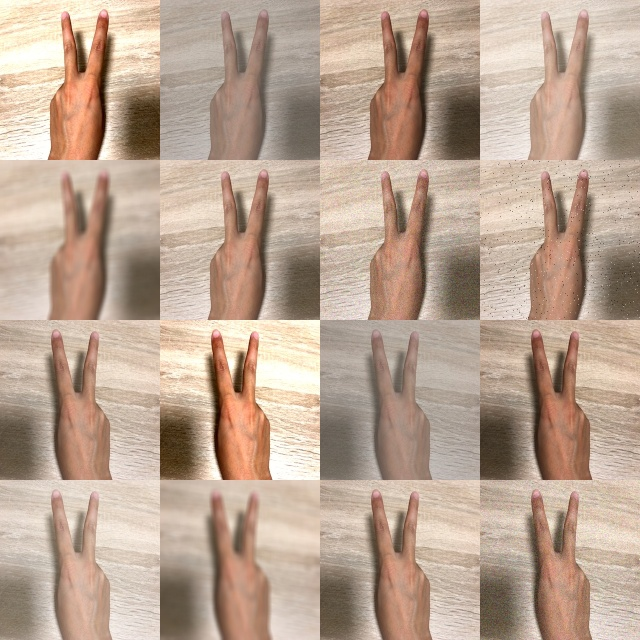

In [ ]:
tmp_file_name = './target_datasets/train_aug/choki/trans_choki_01'

tmp_image = []
for i in range(16):
      tmp_image.append(cv2.imread(tmp_file_name + '_' + str(i) + '.jpg'))

tmp_hconcat_image = []
tmp_hconcat_image.append(cv2.hconcat(tmp_image[0:4]))
tmp_hconcat_image.append(cv2.hconcat(tmp_image[4:8]))
tmp_hconcat_image.append(cv2.hconcat(tmp_image[8:12]))
tmp_hconcat_image.append(cv2.hconcat(tmp_image[12:16]))

concat_image = cv2.vconcat(tmp_hconcat_image[0:4])
concat_image = cv2.resize(concat_image, dsize=(640, 640))
cv2.imwrite('concat.jpg', concat_image)

from IPython.display import Image as IPImage
from IPython.display import display_jpeg
display_jpeg(IPImage('concat.jpg'))

### 学習の事前準備

In [ ]:
train_aug_data = train_data_gen.flow_from_directory(
    train_aug_dir, target_size=(IMAGE_SIZE, IMAGE_SIZE),
    color_mode='rgb', batch_size=BATCH_SIZE,
    class_mode='categorical', shuffle=True)

Found 1998 images belonging to 3 classes.


モデル作成に必要なライブラリのインポート

In [ ]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
#from tensorflow.keras.preprocessing.image import array_to_img, img_to_array, load_img, ImageDataGenerator
import numpy as np
import matplotlib.pyplot as plt
import time

MNISTベースのモデルを作成

In [ ]:
model = Sequential()

model.add(Conv2D(32, (3, 3), padding='same', input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3)))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(128))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(NUM_CLASSES))
model.add(Activation('softmax'))

opt = tf.keras.optimizers.Adam(lr=LEARNING_RATE)
#opt = tf.keras.optimizers.SGD(lr=LEARNING_RATE)

model.compile(opt, loss='categorical_crossentropy', metrics=['accuracy'])

## AIモデルの学習
AIモデルの学習を行います

In [ ]:
%%time
history = model.fit(train_aug_data, epochs=EPOCHS, validation_data=validation_data, verbose=1)

Epoch 1/20
250/250 [==============================] - 5s 19ms/step - loss: 0.4847 - accuracy: 0.8068 - val_loss: 0.3702 - val_accuracy: 0.8750
Epoch 2/20
250/250 [==============================] - 5s 18ms/step - loss: 0.0260 - accuracy: 0.9945 - val_loss: 0.4642 - val_accuracy: 0.8214
Epoch 3/20
250/250 [==============================] - 5s 18ms/step - loss: 0.0284 - accuracy: 0.9920 - val_loss: 0.7352 - val_accuracy: 0.8750
Epoch 4/20
250/250 [==============================] - 5s 19ms/step - loss: 0.0246 - accuracy: 0.9940 - val_loss: 0.4347 - val_accuracy: 0.8750
Epoch 5/20
250/250 [==============================] - 5s 19ms/step - loss: 0.0083 - accuracy: 0.9985 - val_loss: 0.4666 - val_accuracy: 0.8929
Epoch 6/20
250/250 [==============================] - 5s 19ms/step - loss: 0.0243 - accuracy: 0.9930 - val_loss: 0.3581 - val_accuracy: 0.9464
Epoch 7/20
250/250 [==============================] - 5s 19ms/step - loss: 0.0095 - accuracy: 0.9955 - val_loss: 0.5484 - val_accuracy: 0.8929

## 学習結果の可視化

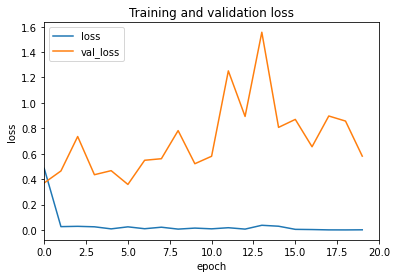

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Training and validation loss')
plt.ylabel('loss')
plt.xlim([0.0, EPOCHS])
plt.xlabel('epoch')
plt.legend(['loss', 'val_loss'], loc='upper left')
plt.show()

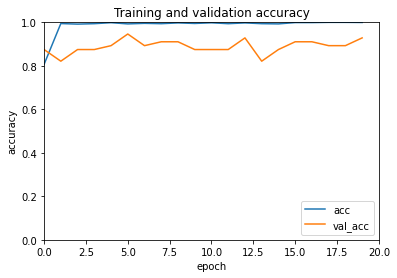

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training and validation accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.xlim([0.0, EPOCHS])
plt.ylim([0.0, 1.0])
plt.legend(['acc', 'val_acc'], loc='lower right')
plt.show()

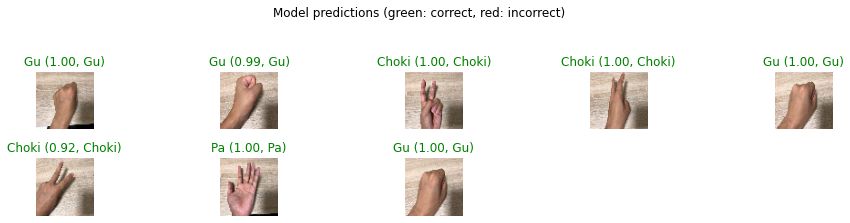

In [ ]:
# Get the ordered list of class names:
import PIL.Image as Image
class_names = validation_data.class_indices.items()
class_names = np.array([key.title() for key, value in class_names])

validation_data.reset()
validation_data.shuffle = True
validation_data.batch_size = BATCH_SIZE

# Retrieve the first batch from the validation data
for validation_image_batch, validation_label_batch in validation_data:
  break

validation_id = np.argmax(validation_label_batch, axis=-1)
validation_label = class_names[validation_id]
predicted_batch = model.predict(validation_image_batch)

# Returns the indices of the maximum values along a given axis
predicted_id = np.argmax(predicted_batch, axis=-1)

# Return the maximum values along a given axis
predicted_score = np.max(predicted_batch, axis=-1)

predicted_label_batch = class_names[predicted_id]

plt.figure(figsize=(16, 9))
plt.subplots_adjust(hspace=0.5)

# Display the classification results for the first 30 images
for n in range(min(validation_image_batch.shape[0], 30)):
  plt.subplot(6, 5, n + 1)

  # Convert the range from -1 to 1 to the range from 0 to 1
  plt.imshow(np.array(validation_image_batch[n]*255,np.int32))
  color = 'green' if predicted_id[n] == validation_id[n] else 'red'
  predicted_label = predicted_label_batch[n].title()
  plt.title(predicted_label + ' ({:.2f}, {})'.format(
      predicted_score[n], validation_label[n]), color=color)
  plt.axis('off')

_ = plt.suptitle('Model predictions (green: correct, red: incorrect)')

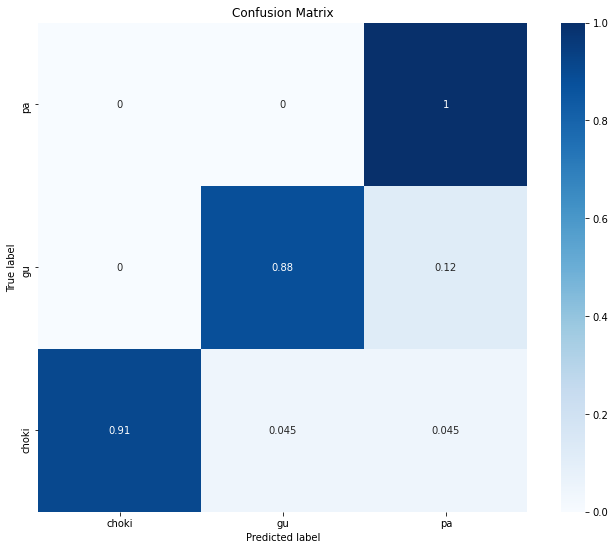

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

validation_data.reset()
validation_data.shuffle =  False
validation_data.batch_size = 1

# Retrieve the first batch from the validation data
for validation_image_batch, validation_label_batch in validation_data:
  break

predicted = model.predict_generator(validation_data, steps=validation_data.n)
predicted_classes = np.argmax(predicted, axis=-1)

# Apply normalization
# https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
cm = confusion_matrix(validation_data.classes, predicted_classes)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(12, 9))

# https://seaborn.pydata.org/generated/seaborn.heatmap.html
# https://matplotlib.org/users/colormaps.html
sns.heatmap(cm, annot=True, square=True, cmap=plt.cm.Blues,
            xticklabels=validation_data.class_indices,
            yticklabels=validation_data.class_indices)

plt.title("Confusion Matrix")
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.xlim([0.0, 3.0])
plt.ylim([0.0, 3.0])
plt.show()

## モデル保存

In [ ]:
save_model_path = os.path.join(backup_dir, 'efficientnet_model.h5')
efficientnet_model.save(save_model_path)

In [ ]:
save_model_path = os.path.join(backup_dir, 'my_model_aug.h5')
model.save(save_model_path)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
!cp './model/efficientnet_model.h5' '/content/drive/My Drive'
!cp './model/my_model_aug.h5' '/content/drive/My Drive'
!cp './model/labels.txt' '/content/drive/My Drive'

# 参考リンク

- https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/images/transfer_learning.ipynb
- http://ni4muraano.hatenablog.com/entry/2019/06/16/084011
- https://qiita.com/wakame1367/items/d90fa56bd9d11c4db50e